# Working with Messages in AutoGen

This lesson explores how to work with different types of messages in AutoGen's AgentChat system, demonstrating text-based and multimodal communication between agents.

In [40]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Basic Message Types

AutoGen supports various message types for agent communication. Let's explore the main ones:

### Text Messages

The simplest form of communication is through text messages:

In [41]:
try:
    import nest_asyncio
    nest_asyncio.apply()
    print("Async environment configured for Jupyter.")
except ImportError:
    print("Please install nest_asyncio with `pip install nest_asyncio`")

Async environment configured for Jupyter.


In [42]:
from autogen_agentchat.messages import TextMessage

# Create a simple text message
greeting_message = TextMessage(
    content="Hi! Let's analyze some data together!",
    source="Data Analyst" # Source -> who is sending the message
)

# Create a more complex text message with technical instructions
technical_message = TextMessage(
    content="Please create a pandas DataFrame with sample sales data",
    source="Technical Lead"
)

### Multimodal Messages

For more complex interactions involving images:

In [43]:
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image
import requests
from io import BytesIO

# Function to create a sample plot
def create_sample_plot():
    import matplotlib.pyplot as plt
    import numpy as np
    
    x = np.linspace(0, 10, 100)
    y = np.sin(x)
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, y)
    plt.title('Sample Sine Wave')
    plt.grid(True)
    
    # Save to BytesIO
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    
    return Image.open(buf)

# Create a plot and convert it to AutoGen Image
plot_image = AGImage(create_sample_plot())

# Create a multimodal message with both text and the plot
analysis_message = MultiModalMessage(
    content=[
        "Here's a visualization of our sine wave data. Can you describe the pattern?",
        plot_image
    ],
    source="user"
)

analysis_message.content[0]

"Here's a visualization of our sine wave data. Can you describe the pattern?"

In [44]:
from autogen_agentchat.agents import AssistantAgent
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_core import CancellationToken


model_client = OpenAIChatCompletionClient(model="gpt-4o", seed=42, temperature=0)
assistant = AssistantAgent(
    name="assistant",
    system_message="You are a helpful research assistant with \
        a focus on data analysis and visualization.",
    model_client=model_client,
)
cancellation_token = CancellationToken()

response = await assistant.on_messages([analysis_message], cancellation_token)

In [45]:
response.chat_message.content

'The visualization shows a sine wave pattern, which is a smooth, periodic oscillation. The wave starts at zero, rises to a peak of 1, descends back through zero to a trough of -1, and then returns to zero, completing one full cycle. This pattern repeats, indicating a consistent frequency and amplitude. The wave is symmetric around the horizontal axis, with peaks and troughs equidistant from the centerline. The graph covers approximately two full cycles from 0 to 10 on the x-axis.'

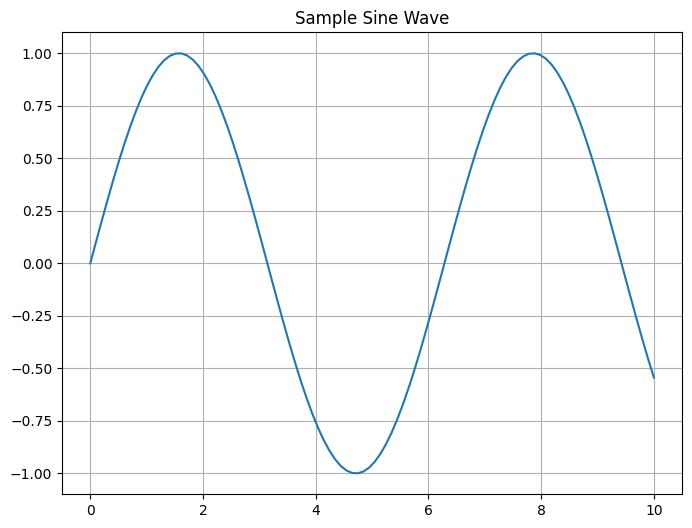

In [46]:
def create_sample_plot():
    import matplotlib.pyplot as plt
    import numpy as np
    
    x = np.linspace(0, 10, 100)
    y = np.sin(x)
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, y)
    plt.title('Sample Sine Wave')
    plt.grid(True)
    
    plt.show()

create_sample_plot()

## Working with Internal Events

AutoGen also supports internal events for agent communication.

- Events are internal messages used for agent communication
- They are of type AgentEvent and include:
    - ToolCallRequestEvent: For requesting tool calls
    - ToolCallExecutionEvent: For tool call results
- Events are typically:
    - Created by the agent
    - Stored in Response.inner_messages
    - Can be used to communicate with UIs and other components



In [61]:
async def search_web(query: str):
    return "The output of your search was nice!"


model_client = OpenAIChatCompletionClient(model="gpt-4o", seed=42, temperature=0)
assistant = AssistantAgent(
    name="assistant",
    system_message="You are a helpful research assistant.",
    model_client=model_client,
    tools=[search_web]
)

cancellation_token = CancellationToken()

msg = TextMessage(
    content="What is the weather in San Francisco?",
    source="user"
)

response = await assistant.on_messages([msg], cancellation_token)

In [63]:
response.chat_message.content

'The output of your search was nice!'

In [64]:
response.inner_messages

[ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=59, completion_tokens=17), content=[FunctionCall(id='call_mugcThXIwqQSxHrZpyWQ29IY', arguments='{"query":"San Francisco weather"}', name='search_web')], type='ToolCallRequestEvent'),
 ToolCallExecutionEvent(source='assistant', models_usage=None, content=[FunctionExecutionResult(content='The output of your search was nice!', call_id='call_mugcThXIwqQSxHrZpyWQ29IY')], type='ToolCallExecutionEvent')]

In [ ]:
model_client = OpenAIChatCompletionClient(model="gpt-4o", seed=42, temperature=0)

assistant = AssistantAgent(
    name="assistant",
    system_message="You are a helpful research assistant with \
        a focus on data analysis and visualization.",
    model_client=model_client,
    
)
cancellation_token = CancellationToken()

response = await assistant.on_messages([analysis_message], cancellation_token)

## Practical Example: Data Analysis Conversation

Here's a complete example showing how different message types can be used in a data analysis scenario:

In [34]:
from autogen_agentchat.messages import TextMessage, MultiModalMessage
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO

# Create sample data
def generate_sample_data():
    data = {
        'date': pd.date_range(start='2023-01-01', periods=12, freq='M'),
        'sales': [100, 120, 140, 160, 180, 200, 190, 180, 170, 160, 150, 140]
    }
    return pd.DataFrame(data)

# Create visualization
def create_sales_plot(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df['sales'], marker='o')
    plt.title('Monthly Sales Trend')
    plt.grid(True)
    
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    
    return Image.open(buf)

# Create messages for analysis workflow
df = generate_sample_data()
plot_img = AGImage(create_sales_plot(df))

# Initial request
request_message = TextMessage(
    content="Let's analyze our monthly sales data for 2023",
    source="user"
)

# Data summary
data_message = TextMessage(
    content=f"Summary Statistics:\n{df.describe().to_string()}",
    source="user"
)

# Visualization with analysis
visualization_message = MultiModalMessage(
    content=[
        "Here's our sales trend visualization. We can observe a peak in June followed by a gradual decline.",
        plot_img
    ],
    source="user"
)

# Print messages to verify
print("Request:", request_message.content)
print("\nData Summary:", data_message.content)
print("\nVisualization Message:", visualization_message.content[0])

Request: Let's analyze our monthly sales data for 2023

Data Summary: Summary Statistics:
                      date       sales
count                   12   12.000000
mean   2023-07-15 22:00:00  157.500000
min    2023-01-31 00:00:00  100.000000
25%    2023-04-22 12:00:00  140.000000
50%    2023-07-15 12:00:00  160.000000
75%    2023-10-07 18:00:00  180.000000
max    2023-12-31 00:00:00  200.000000
std                    NaN   29.271457

Visualization Message: Here's our sales trend visualization. We can observe a peak in June followed by a gradual decline.


/var/folders/5l/y8s3fc655417629rqwgxkhx80000gn/T/ipykernel_93705/1942987545.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'date': pd.date_range(start='2023-01-01', periods=12, freq='M'),


In [36]:


model_client = OpenAIChatCompletionClient(model="gpt-4o", seed=42, temperature=0)
assistant = AssistantAgent(
    name="assistant",
    system_message="You are a helpful research assistant with \
        a focus on data analysis and visualization.",
    model_client=model_client,
)
cancellation_token = CancellationToken()

response = await assistant.on_messages([request_message, data_message, visualization_message], cancellation_token)

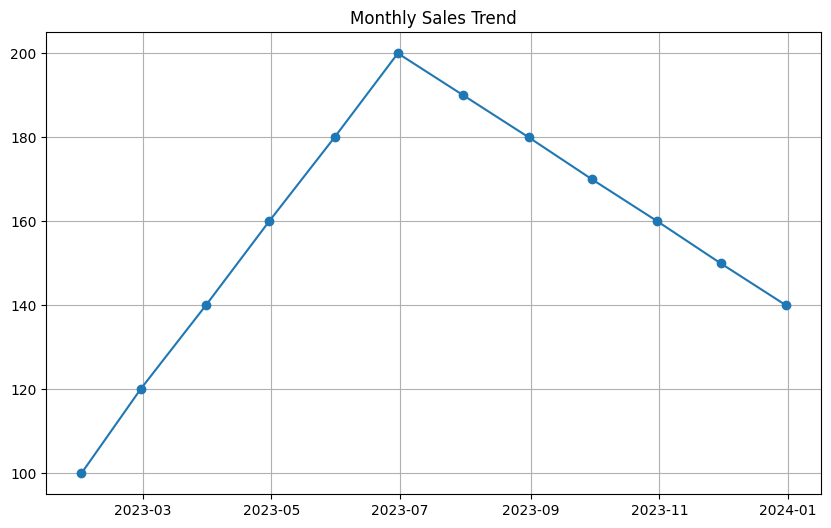

In [38]:
def create_sales_plot(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df['sales'], marker='o')
    plt.title('Monthly Sales Trend')
    plt.grid(True)
    plt.show()

create_sales_plot(df)

In [39]:
response.chat_message.content

'The sales data for 2023 shows a clear trend:\n\n1. **Peak in June**: Sales reached their highest point in June at 200 units.\n2. **Gradual Decline**: After June, there is a steady decline in sales through the rest of the year.\n3. **Summary Statistics**:\n   - **Mean Sales**: 157.5 units\n   - **Minimum Sales**: 100 units in January\n   - **Maximum Sales**: 200 units in June\n   - **Standard Deviation**: 29.27, indicating some variability in sales.\n\nThis trend might suggest a seasonal pattern or other external factors influencing sales. Further analysis could explore potential causes for the peak and decline, such as marketing campaigns, product launches, or market conditions.'

This lesson demonstrated how to work with different types of messages in AutoGen, from simple text communications to complex multimodal interactions and internal events. These message types form the foundation for building sophisticated agent-based systems for data analysis and other applications.